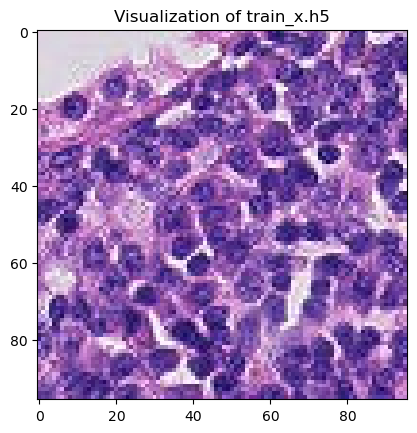

In [7]:
import os
import h5py
import matplotlib.pyplot as plt


folder_path = '/Users/ramsesnestor/Desktop/data'


file_to_dataset = {
    'train_x.h5': 'x',
    'train_y.h5': 'y',
    'valid_x.h5': 'x',
    'valid_y.h5': 'y',
    'test_x.h5': 'x',
    'test_y.h5': 'y'
}


for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
       
        dataset = file[dataset_name]
        
        
        data = dataset[:]
        
 
        
      
        if 'train_x.h5' in filename:
            plt.imshow(data[0], cmap='gray')  
            plt.title(f'Visualization of {filename}')
            plt.show()


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model

In [9]:
x_train, y_train, x_valid, y_valid, x_test, y_test = None, None, None, None, None, None


for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
        
        dataset = file[dataset_name]
        
        
        if 'train_x.h5' in filename:
            x_train = dataset[:]
        elif 'train_y.h5' in filename:
            y_train = dataset[:]
        elif 'valid_x.h5' in filename:
            x_valid = dataset[:]
        elif 'valid_y.h5' in filename:
            y_valid = dataset[:]
        elif 'test_x.h5' in filename:
            x_test = dataset[:]
        elif 'test_y.h5' in filename:
            y_test = dataset[:]

In [10]:
len(x_train), len(y_train), len(x_valid), len(y_valid), len(x_test), len(y_test)

(262144, 262144, 32768, 32768, 32768, 32768)

In [11]:
#checking for class imbalance

import numpy as np

unique_classes, class_counts = np.unique(y_train, return_counts=True)

for i, class_count in enumerate(class_counts):
    class_name = unique_classes[i]
    print(f"Class {class_name}: {class_count} samples")


Class 0: 131072 samples
Class 1: 131072 samples


In [12]:
x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [13]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


datagen.fit(x_train)


In [15]:
x_train = x_train.reshape(x_train.shape[0], 96, 96, 3)
x_valid = x_valid.reshape(x_valid.shape[0], 96, 96, 3)
x_test = x_test.reshape(x_test.shape[0], 96, 96, 3)


In [16]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [17]:
x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model_1 = Sequential([
    Flatten(input_shape=(96, 96, 3)),  
    Dense(128, activation='relu'), 
    Dense(1, activation='sigmoid')  
])

# Compile the model
model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

# Summarize the model architecture
model_1.summary()

In [ ]:
history_1 = model_1.fit(datagen.flow(x_train_final, y_train_final, batch_size=16), validation_data=(x_val_final, y_val_final),
                    
                     steps_per_epoch=len(x_train_final)/16, epochs=10)

In [ ]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_1.history['recall'], label='Training Recall')
plt.plot(history_1.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
model_2 = Sequential([
    Flatten(input_shape=(96, 96, 3)),
    Dense(512, activation='relu', kernel_regularizer='l2'),
    Dense(1024, activation='relu', kernel_regularizer='l2'),  
    Dense(2048, activation='relu', kernel_regularizer='l2'),  
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Recall'])

model_2.summary()

Metal device set to: Apple M2 Max


2023-09-18 22:38:53.358908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-18 22:38:53.361719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 512)               14156288  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 16,782,849
Trainable params: 16,782,849
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_2 = model_2.fit(datagen.flow(x_train_final, y_train_final, batch_size=16), 
                                    validation_data=(x_val_final, y_val_final),
                                    steps_per_epoch=len(x_train_final)/16, epochs=10)

Epoch 1/10


2023-09-18 22:38:54.206408: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-18 22:38:54.476101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14746/14745 [==============================] - ETA: 0s - loss: 0.8702 - accuracy: 0.5000 - recall: 0.5114

2023-09-18 22:44:47.794225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14745/14745 [==============================] - 358s 24ms/step - loss: 0.8702 - accuracy: 0.5000 - recall: 0.5114 - val_loss: 0.6932 - val_accuracy: 0.4991 - val_recall: 1.0000
Epoch 2/10
14745/14745 [==============================] - 1214s 82ms/step - loss: 0.6932 - accuracy: 0.5002 - recall: 0.5117 - val_loss: 0.6932 - val_accuracy: 0.5009 - val_recall: 0.0000e+00
Epoch 3/10
14745/14745 [==============================] - 274s 19ms/step - loss: 0.6932 - accuracy: 0.5003 - recall: 0.4445 - val_loss: 0.6932 - val_accuracy: 0.4991 - val_recall: 1.0000
Epoch 4/10
14745/14745 [==============================] - 385s 26ms/step - loss: 0.6932 - accuracy: 0.4995 - recall: 0.4837 - val_loss: 0.6932 - val_accuracy: 0.4991 - val_recall: 1.0000
Epoch 5/10
14745/14745 [==============================] - 277s 19ms/step - loss: 0.6932 - accuracy: 0.5006 - recall: 0.5215 - val_loss: 0.6932 - val_accuracy: 0.5009 - val_recall: 0.0000e+00
Epoch 6/10
14745/14745 [==============================] - 269s 18ms

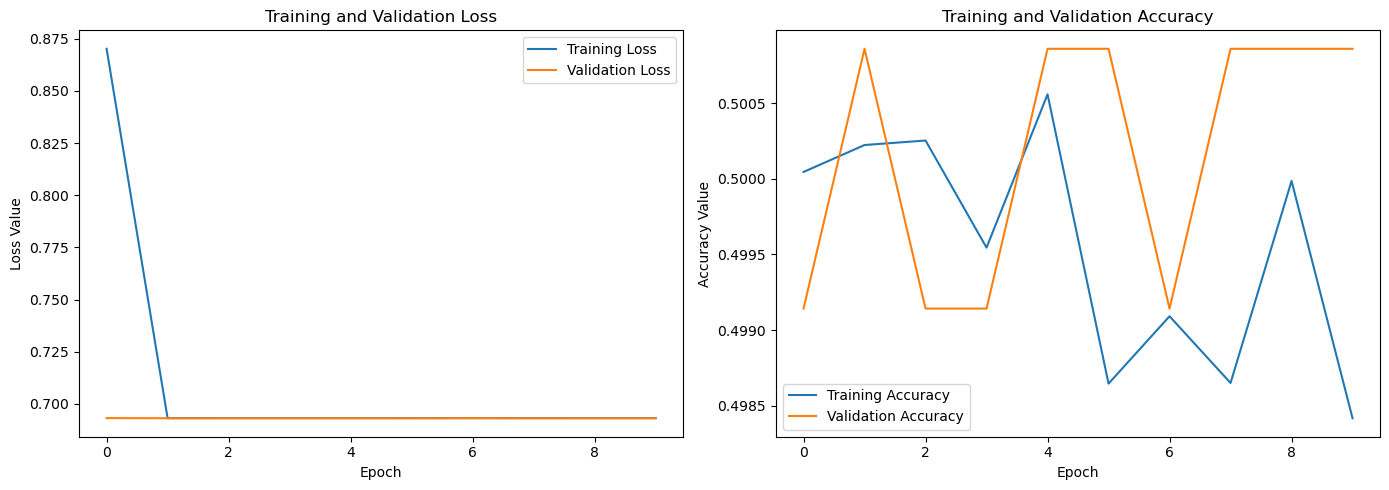

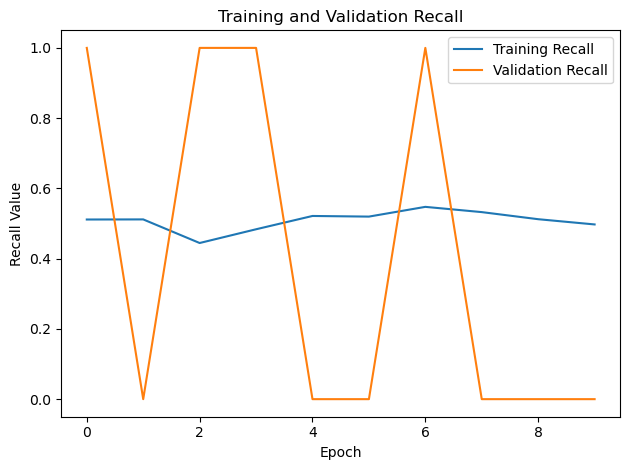

In [20]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_2.history['recall'], label='Training Recall')
plt.plot(history_2.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
model_cnn = Sequential()

# Convolutional layers
model_cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))

# Fully connected layers
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the CNN model
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 47, 47, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 45, 45, 64)        36928     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 20, 20, 256)       147712    
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 10, 10, 256)    

In [38]:
history_cnn = model_cnn.fit(datagen.flow(x_train_final, y_train_final, batch_size=16), 
                                    validation_data=(x_val_final, y_val_final),
                                    steps_per_epoch=len(x_train_final)/16, epochs=20)

Epoch 1/20


2023-09-19 10:42:10.901000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14746/14745 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8064 - recall: 0.8153

2023-09-19 10:46:28.414260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14745/14745 [==============================] - 266s 18ms/step - loss: 0.4254 - accuracy: 0.8064 - recall: 0.8153 - val_loss: 0.3283 - val_accuracy: 0.8621 - val_recall: 0.8594
Epoch 2/20
14745/14745 [==============================] - 329s 22ms/step - loss: 0.3424 - accuracy: 0.8530 - recall: 0.8534 - val_loss: 0.3176 - val_accuracy: 0.8689 - val_recall: 0.8008
Epoch 3/20
14745/14745 [==============================] - 287s 19ms/step - loss: 0.3143 - accuracy: 0.8660 - recall: 0.8618 - val_loss: 0.2615 - val_accuracy: 0.8911 - val_recall: 0.8623
Epoch 4/20
14745/14745 [==============================] - 288s 19ms/step - loss: 0.2959 - accuracy: 0.8760 - recall: 0.8700 - val_loss: 0.2968 - val_accuracy: 0.8796 - val_recall: 0.8041
Epoch 5/20
14745/14745 [==============================] - 298s 20ms/step - loss: 0.2841 - accuracy: 0.8815 - recall: 0.8752 - val_loss: 0.2620 - val_accuracy: 0.8925 - val_recall: 0.8585
Epoch 6/20
14745/14745 [==============================] - 295s 20ms/step - l

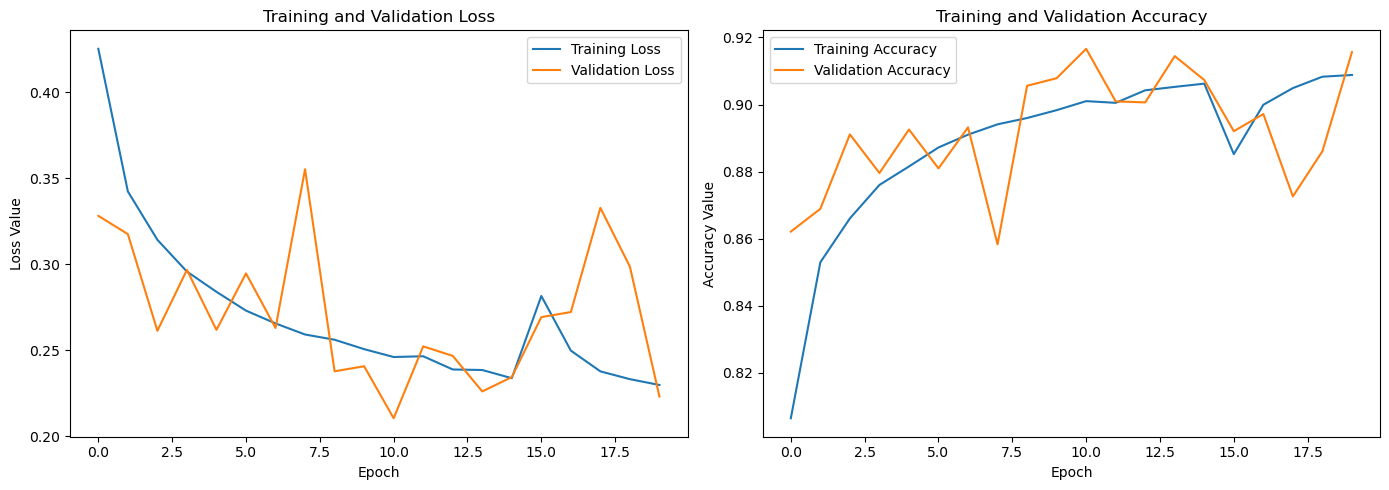

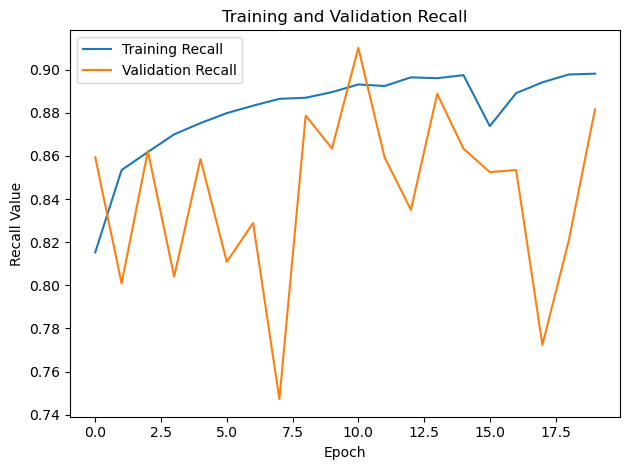

In [39]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_cnn.history['recall'], label='Training Recall')
plt.plot(history_cnn.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:

from hyperopt import fmin, tpe, hp, Trials
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import recall_score

# Define the search space for hyperparameters
space = {
    'learning_rate': hp.loguniform('learning_rate', -6, 0),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'num_filters': hp.choice('num_filters', [32, 64, 128]),
    'kernel_size': hp.choice('kernel_size', [(3, 3), (5, 5), (7, 7)]),
    'num_dense_layers': hp.choice('num_dense_layers', [1, 2, 3]),
    'num_dense_units': hp.choice('num_dense_units', [256, 512, 1024]),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop', 'sgd']),
}

# Define the objective function to optimize
def objective(params):
    # Create a new instance of the model
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(params['num_filters'], params['kernel_size'], activation='relu', input_shape=(96, 96, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(params['num_filters'], params['kernel_size'], activation='relu'))
    model.add(MaxPooling2D(2, 2))
    
    # Flatten layer
    model.add(Flatten())
    
    # Dense layers
    for _ in range(params['num_dense_layers']):
        model.add(Dense(params['num_dense_units'], activation='relu'))
        model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with the given learning rate and optimizer
    optimizer = params['optimizer']
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'])
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=params['learning_rate'])
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=params['learning_rate'])
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])
    
    # Train the model
    model.fit(datagen.flow(x_train_final, y_train_final, batch_size=params['batch_size']),
              validation_data=(x_val_final, y_val_final),
              steps_per_epoch=len(x_train_final) // params['batch_size'],
              epochs=20,
              verbose=0)
    
    # Evaluate the model on validation data
    y_pred = model.predict(x_val_final)
    y_pred = (y_pred > 0.5).astype(int)
    recall = recall_score(y_val_final, y_pred)
    
    # Return the negative recall (as hyperopt minimizes the objective)
    return -recall

# Perform Bayesian optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

print("Best hyperparameters:", best)

ModuleNotFoundError: No module named 'hyperopt'

In [43]:
   import sys
   print(sys.executable)


/Users/ramsesnestor/miniconda3/envs/learn-env-tensor/bin/python
